
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW-Q : Overtopping estimation of historical nearshore waves at 3 locations

inputs required: 
  * Nearshore reconstructed historical **waves**
  * Historical water levels

in this notebook:
  * HyCReWW-Q overtopping estimation of historical events
  

**HyCReWW - Q** provides wave-driven overtopping estimations along coral reef-lined shorelines under a wide range of fringing reef morphologies and offshore forcing characteristics. The metamodel is based on two models: (a) a full factorial design of recent XBeach Non-Hydrostatic simulations under different reef configurations and offshore wave and water level conditions (Pearson et al, 2017); and (b) Radial Basis Functions (RBFs) for approximating the non-linear function of overtopping for the set of multivariate parameters:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Runup = RBF($\eta_0$, $H_0$, ${H_0/L_0}$, $\beta_f$,$W_{reef}$, $\beta_b$, $c_f$, $Z_b$ );&nbsp;&nbsp;&nbsp;&nbsp;</center>

Where, the hydrodynamic variables defined are offshore water level ($\eta_0$), significant wave height ($H_0$), and wave steepness (${H_0/L_0}$); the reef morphologic parameters include fore reef slope ($\beta_f$), reef flat width ($W_reef$), beach slope ($\beta_b$), seabed roughness ($c_f$) and beach crest elevation ($Z_b$). ${L_0}$ is the deep water wave length $L_0=gT_p^2/2pi$, and $T_p$ is the peak period.

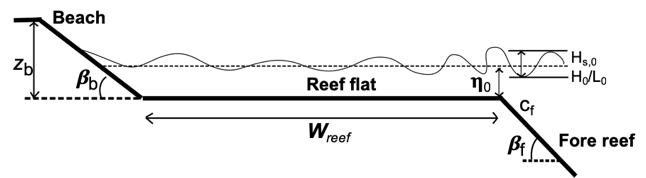

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import linregress
from datetime import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize
from teslakit.statistical import runmean
from teslakit.tides import Calculate_MMSL


from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


# --------------------------------------
# parameters for mmsl calculation
mmsl_year_ini = 1996
mmsl_year_end = 2017


# --------------------------------------
# load Hycreww RBF coefficients and sim. variables min. and max.
var_lims, rbf_coeffs = db.Load_HYCREWW_Q()


# --------------------------------------
# Select profiles to estimate overtopping: ALL

# reef characteristics (AlbaR)
xds_reef = xr.open_dataset(op.join(p_data, 'inputs_Kwajalein','datos_perfiles_albaR','data_profiles.nc'))
print(xds_reef)
print()

# Zbeach characteristics (Sara)
xds_Zbeach = xr.open_dataset(op.join(p_data, 'inputs_Kwajalein','datos_perfiles_sara','zBeach_perimeter1.nc'))
xds_Zbeach = xds_Zbeach.drop({'xcoor', 'ycoor'})
print(xds_Zbeach)
print()


# --------------------------------------
# Load nearshore waves
WAVES_N = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/WAVES/wind_output_N.nc')) # hourly
WAVES_S = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/WAVES/agg_PS_15m.nc')) # 3-hourly
WAVES_E = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/WAVES/agg_PE_15m.nc')) # 3-hourly

# to hourly and same dates
WAVES_N = WAVES_N.sel(time=slice(WAVES_S.time.values[0], WAVES_S.time.values[-1]))
WAVES_S = WAVES_S.resample(time='1H').interpolate('linear')
WAVES_E = WAVES_E.resample(time='1H').interpolate('linear')

# join in one file
WAVES_S = WAVES_S.drop('tp')
WAVES_E = WAVES_E.drop('tp')
WAVES_E = WAVES_E.rename_vars({"tm": "tp"})  # rename vars
WAVES_S = WAVES_S.rename_vars({"tm": "tp"})  # rename vars

WAVES = xr.concat([WAVES_N, WAVES_S, WAVES_E], dim='profile')
print(WAVES)



<xarray.Dataset>
Dimensions:      (profile: 36)
Coordinates:
  * profile      (profile) int64 36 35 34 33 32 31 30 29 28 ... 8 7 6 5 4 3 2 1
Data variables:
    zBeach       (profile) float64 ...
    Wreef        (profile) int64 ...
    Fore Slope   (profile) float64 ...
    Beach Slope  (profile) float64 ...
    Toe Fore     (profile) int64 ...
    Lon Start    (profile) float64 ...
    Lon End      (profile) float64 ...
    Lat Start    (profile) float64 ...
    Lat End      (profile) float64 ...

<xarray.Dataset>
Dimensions:  (profile: 36)
Coordinates:
  * profile  (profile) int64 1 2 3 4 5 6 7 8 9 10 ... 28 29 30 31 32 33 34 35 36
Data variables:
    zBeach   (profile) float64 ...

<xarray.Dataset>
Dimensions:  (profile: 36, time: 359401)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
  * profile  (profile) float64 22.0 23.0 24.0 25.0 26.0 ... 18.0 19.0 20.0 21.0
Data variables:
    hs       (time, profile) float64 0.5726 0.5733 0.5745


## Hycreww RBF Interpolation

### VARIABLES

##### Obtain Historical levels time series:

In [3]:
# --------------------------------------
# Astronomical Tide (AT)

_, TIDE = db.Load_TIDE_hist()  
TIDE = TIDE.drop_vars('ntr')
TIDE = TIDE.drop_vars('sigma')
print(TIDE)

AT = (TIDE.predicted - np.nanmean(TIDE.predicted.values[:])) 


<xarray.Dataset>
Dimensions:    (time: 184104)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 ... 2016-12-31T23:00:00.000002944
Data variables:
    observed   (time) float64 ...
    predicted  (time) float64 ...


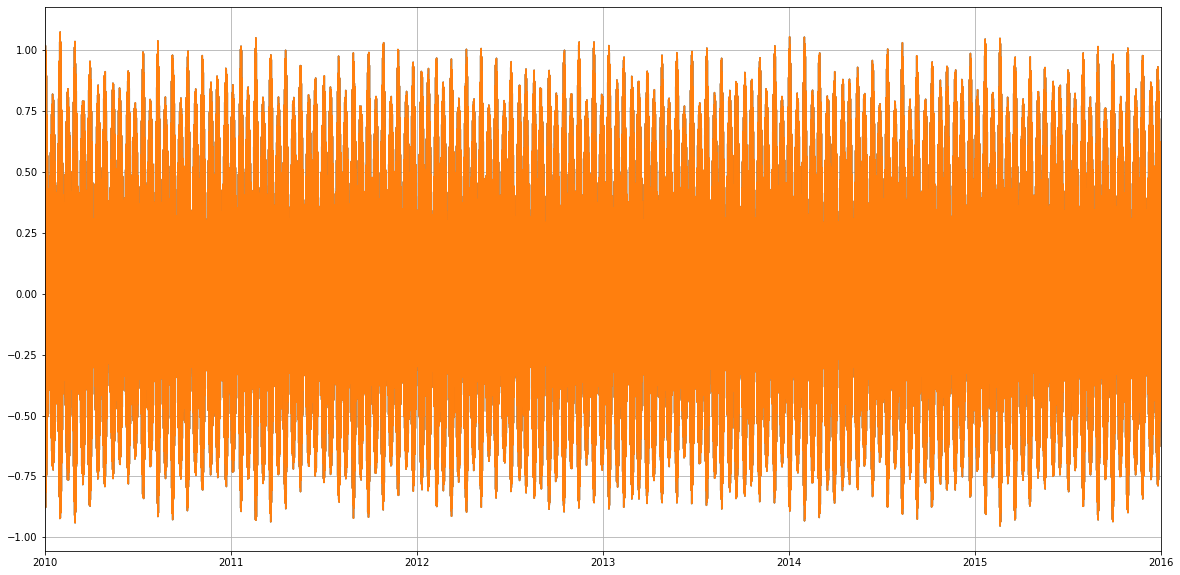

In [19]:
# plot High Tide Flooding Event – Jan 31-Feb 1, 2014 (ppt)

plt.figure(figsize=(20,10))
plt.plot(AT.time, AT)
plt.xlim(datetime(2010,1,1),datetime(2016,1,1))
plt.plot(AT.time, AT)
#plt.xlim(datetime(2014,1,20),datetime(2014,2,10))
plt.grid()


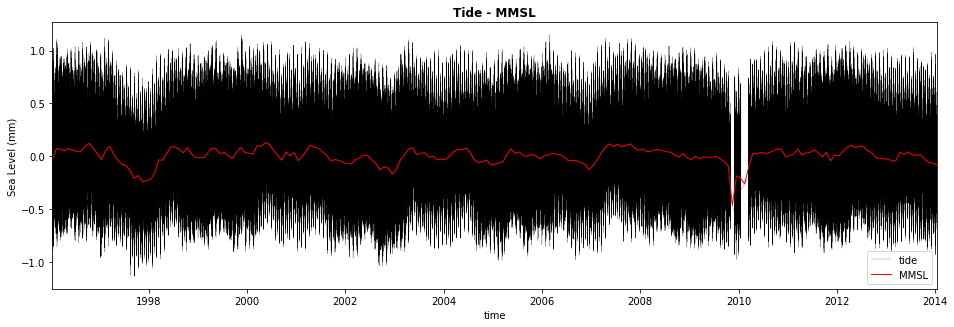

In [4]:
# --------------------------------------
# Monthly Mean Sea Level (MMSL)

SL = (TIDE.observed - np.nanmean(TIDE.observed.values[:]))
SL = SL.dropna(dim='time')
SL = SL.resample(time='1H').interpolate("linear")

# obtain SLR
lr_time = np.array(range(len(SL.time)))  # for linregress
ind_nan = np.where(~np.isnan(SL.values)) # ind no NaNs
slope, intercept, r_value, p_value, std_err = linregress(lr_time[ind_nan], SL.values[ind_nan])
slr = intercept + slope * lr_time

# Plot tide with SLR
#Plot_Tide_SLR(SL.time, SL, slr);

# remove SLR and runmean from tide 
SL_noslr = SL - slr

# calculate running mean
time_window = 365*24*3
runm = runmean(SL_noslr, time_window, 'mean')

# Plot SL without SLR and runm
#Plot_Tide_RUNM(time, SL_noslr, runm);

# remove running mean
SL_noslr_norunm = SL_noslr - runm

# store data 
SLNSR = xr.DataArray(SL_noslr_norunm,  dims=('time'), coords={'time':SL.time.values})

# calculate MMSL
MMSL = Calculate_MMSL(SLNSR, mmsl_year_ini, mmsl_year_end)
mmsl_time = MMSL.time.values[:]
mmsl_vals = MMSL.mmsl.values[:]

# Plot tide and mmsl 
Plot_Tide_MMSL(SLNSR.time, SLNSR.values, mmsl_time, mmsl_vals);

# store historical mmsl
db.Save_TIDE_hist_mmsl(MMSL)


# from monthly to hourly
MMSL = MMSL.mmsl.resample(time='1H').interpolate("linear")


In [5]:
# --------------------------------------
# Inverse Barometer (IB)

SLP = db.Load_ESTELA_SLP()                # Sea Level Pressure from CFSR (Pa)
SLP_p = SLP.sel(longitude = 168, latitude = 8) # pnt_lon = 167.73, pnt_lat = 8.66


IB = xr.Dataset({'SLP': (('time',), ((SLP_p.SLP - np.mean(SLP_p.SLP.values)) * 0.01))}, # (mb)
                         coords = {'time': SLP_p.time.values})

IB['level'] = (('time'), -1*IB.SLP) # (cm)


<xarray.DataArray 'predicted' (time: 157776)>
array([ 0.40100827,  0.56500827,  0.61900827, ..., -0.50999173,
       -0.64299173, -0.61399173])
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
<xarray.DataArray 'mmsl' (time: 157776)>
array([-0.02968394, -0.02954135, -0.02939876, ..., -0.0871816 ,
       -0.08721253, -0.08724345])
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
Attributes:
    units:       meters
    short_name:  mmsl
    long_name:   monthly mean sea level
<xarray.Dataset>
Dimensions:  (time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
Data variables:
    SLP      (time) float64 0.7054 -0.3889 -0.8767 ... -0.8633 -0.5786 -0.6715
    level    (time) float64 -0.7054 0.3889 0.8767 1.007 ... 0.8633 0.5786 0.6715

<xarray.DataArray (time: 157776)>
array([ 0.36427028,  0.53935584,  0.59837655, ..., -0.58854067,
       -0.72441847, -0.69452049])
Coordinates:
  *

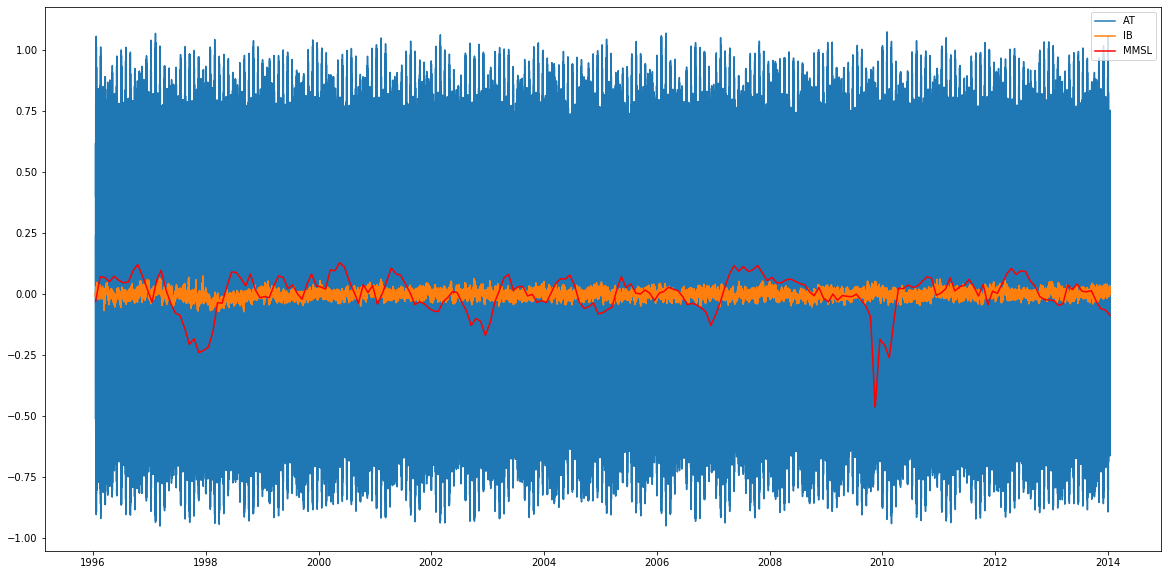

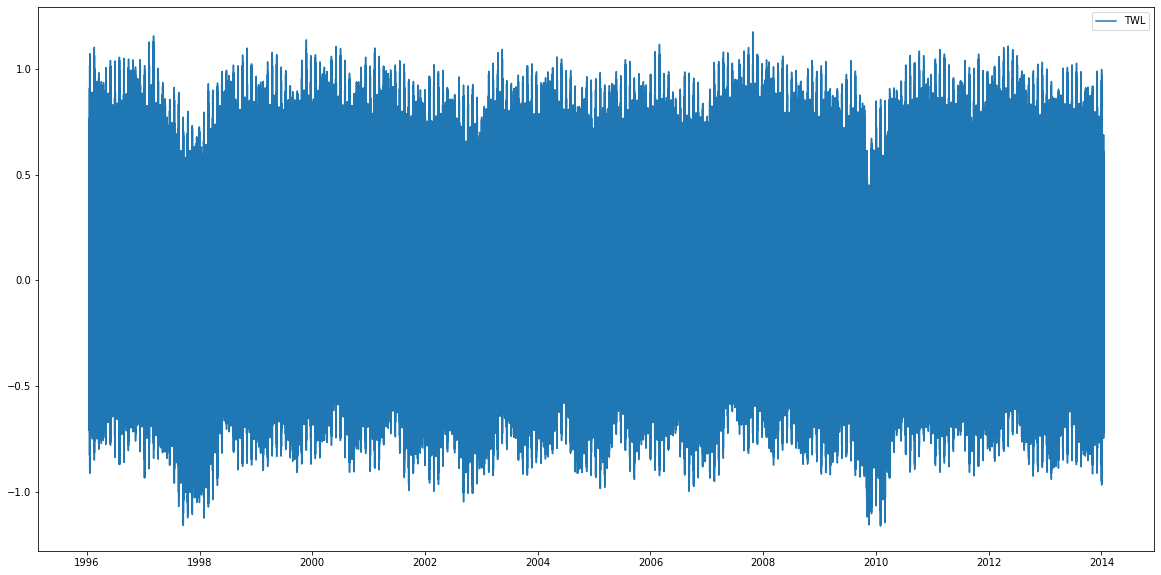

In [6]:
# --------------------------------------
# Compute Total Water Level (TWL)

# hourly values
AT['time'] = AT['time'].dt.round('H')
MMSL['time'] = MMSL['time'].dt.round('H')
IB['time'] = IB['time'].dt.round('H')

# remove duplicates
_, ix = np.unique(AT['time'], return_index=True); AT = AT.isel(time=ix)
_, ix = np.unique(MMSL['time'], return_index=True); MMSL = MMSL.isel(time=ix)
_, ix = np.unique(IB['time'], return_index=True); IB = IB.isel(time=ix)


# get common dates
AT = AT.sel(time = slice('1996-01-17', '2014-01-15'))
MMSL = MMSL.sel(time = slice('1996-01-17', '2014-01-15'))
IB = IB.sel(time = slice('1996-01-17', '2014-01-15'))

print(AT)
print(MMSL)
print(IB)
print()

level = AT + MMSL + IB.level/100.0
print(level)


# save
level = level.to_dataset(name='level')
level.to_netcdf(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_TWL.nc'))
print(level)


# plot
plt.figure(figsize=(20,10))
plt.plot(AT.time, AT, label='AT')
plt.plot(IB.time, IB.level/100.0, label='IB')
plt.plot(MMSL.time, MMSL, color = 'r', label='MMSL')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(level.time, level.level, label = 'TWL')
plt.legend()


In [7]:
level = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_TWL.nc'))
print(level)

<xarray.Dataset>
Dimensions:  (time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
Data variables:
    level    (time) float64 ...


##### Set parameters for Hycreww: TWL, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf

In [4]:
# Combine the 2 datasets (waves, reef characteristics and the modified Zbeach)

xds_reef_t = xr.Dataset(
            {   'bslope':(('time','profile'), np.ones((len(WAVES.time),len(xds_reef.profile)))*xds_reef['Beach Slope'].values),
                'rslope':(('time','profile'), np.ones((len(WAVES.time),len(xds_reef.profile)))*xds_reef['Fore Slope'].values),
                'rwidth':(('time','profile'), np.ones((len(WAVES.time),len(xds_reef.profile)))*xds_reef['Wreef'].values),                
                'cf':(('time','profile'), np.ones((len(WAVES.time),len(xds_reef.profile)))*0.1),
            },
    coords = {'time': WAVES.time.values,
              'profile': xds_reef.profile.values})

xds_Zbeach_t = xr.Dataset(
            {   'Zb':(('time','profile'), np.ones((len(WAVES.time),len(xds_Zbeach.profile)))*xds_Zbeach['zBeach'].values),                
            },
    coords = {'time': WAVES.time.values,
              'profile': xds_Zbeach.profile.values})


dset = xr.merge([WAVES, xds_reef_t, xds_Zbeach_t])
print(dset)


<xarray.Dataset>
Dimensions:  (profile: 36, time: 359401)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
Data variables:
    hs       (time, profile) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tp       (time, profile) float64 nan nan nan nan ... 3.705 3.705 3.705 3.705
    dir      (time, profile) float64 0.0 0.0 0.0 0.0 ... 181.6 175.2 179.1 186.0
    bslope   (time, profile) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3
    rslope   (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.02 0.02 0.02 0.02
    rwidth   (time, profile) float64 235.0 200.0 130.0 10.0 ... 0.0 0.0 0.0 0.0
    cf       (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    Zb       (time, profile) float64 1.658 4.422 2.231 ... 3.359 2.344 3.006


In [5]:
# Add needed Hycreww params

dset = dset.sel(time=level.time)

level_t = np.tile(level.level.sel(time=dset.time).values, (36,1))
level_t = np.transpose(level_t)

dset['level'] = (('time','profile'), level_t)

dset['hs_lo2'] = (dset.hs/(1.5613*dset.tp**2))

print(dset)

<xarray.Dataset>
Dimensions:  (profile: 36, time: 157776)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
Data variables:
    hs       (time, profile) float64 1.087 1.164 1.212 ... 0.02493 0.03242
    tp       (time, profile) float64 5.2 5.199 5.191 5.144 ... 3.553 3.553 3.553
    dir      (time, profile) float64 164.8 159.8 156.0 ... 174.0 177.8 184.8
    bslope   (time, profile) float64 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3
    rslope   (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.02 0.02 0.02 0.02
    rwidth   (time, profile) float64 235.0 200.0 130.0 10.0 ... 0.0 0.0 0.0 0.0
    cf       (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    Zb       (time, profile) float64 1.658 4.422 2.231 ... 3.359 2.344 3.006
    level    (time, profile) float64 0.3643 0.3643 0.3643 ... -0.6945 -0.6945
    hs_lo2   (time, profile) float64 0.02574 0.02757

In [6]:
# Adjust variables to fit within Hycreww limits

for var in var_lims.keys():
    
    dset[var] =  dset[var].where(dset[var]>=var_lims[var][0], var_lims[var][0] )
    dset[var] =  dset[var].where(dset[var]<=var_lims[var][1], var_lims[var][1] )    
    

print(dset)


<xarray.Dataset>
Dimensions:  (profile: 36, time: 157776)
Coordinates:
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
Data variables:
    hs       (time, profile) float64 1.087 1.164 1.212 1.104 ... 1.0 1.0 1.0 1.0
    tp       (time, profile) float64 5.2 5.199 5.191 5.144 ... 3.553 3.553 3.553
    dir      (time, profile) float64 164.8 159.8 156.0 ... 174.0 177.8 184.8
    bslope   (time, profile) float64 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2
    rslope   (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.05 0.05 0.05 0.05
    rwidth   (time, profile) float64 235.0 200.0 130.0 10.0 ... 0.0 0.0 0.0 0.0
    cf       (time, profile) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    Zb       (time, profile) float64 1.658 4.0 2.231 2.058 ... 3.359 2.344 3.006
    level    (time, profile) float64 0.3643 0.3643 0.3643 ... -0.6945 -0.6945
    hs_lo2   (time, profile) float64 0.025

### HyCReWW-Q

In [7]:
# HyCReWW Function

def hycreww_Q(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (WL, Hs, Tp, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf )
    
    '''
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'Zb', 'cf']

    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4, 5]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]


    # discard data outside limits
#     for vn in var_lims.keys():
#         dset = dset.isel(num=np.where((dset[vn] >= var_lims[vn][0]) & (dset[vn] <= var_lims[vn][1]))[0])


    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]
    ds_in=([dset.level.values],[dset.rslope.values],[dset.bslope.values],[dset.rwidth.values],[dset.Zb.values],[dset.cf.values])
    ds_in=np.transpose(ds_in)[:,0,:]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)

    # Q Linear interpolation (hs, hs_lo -> runup)
    Q = []
    for c  in range(len(dset.time)):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (dset.hs.values[c], dset.hs_lo2.values[c]), method='linear')
        Q.append(vq)
    Q = np.array(Q)

    # store runup alongside input data
    dset_out = dset.copy()  
    dset_out['Q'] = (('time'),Q)

    return dset_out

In [8]:
# Compute Hycreww-Q

for p in dset.profile.values:
    print(p)
    
    dset_p = dset.sel(profile=p)

    out_sim_p = hycreww_Q(var_lims, rbf_coeffs, dset_p)
        
    if p==1:
        out_sim = out_sim_p
    else:
        out_sim = xr.concat([out_sim, out_sim_p], dim='profile')
    
    
print(out_sim)

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
<xarray.Dataset>
Dimensions:  (profile: 36, time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
Data variables:
    hs       (profile, time) float64 1.087 1.095 1.103 1.111 ... 1.0 1.0 1.0 1.0
    tp       (profile, time) float64 5.2 5.272 5.345 5.417 ... 3.538 3.606 3.553
    dir      (profile, time) float64 164.8 164.8 164.7 ... 183.9 185.8 184.8
    bslope   (profile, time) float64 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2
    rslope   (profile, time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.05 0.05 0.05 0.05
    rwidth   (profile, time) float64 235.0 235.0 235.0 235.0 ... 0.0 0.0 0.0 0.0
    cf       (profile, time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    Zb       (profile, time) 

### We undo the box-cox transformation

In [9]:
from scipy.special import boxcox, inv_boxcox

# inv_boxcox(y, lmbda) 
# y = (x**lmbda - 1) / lmbda  if lmbda != 0
#     log(x)                  if lmbda == 0
    
out_sim['Qinv'] = (('profile', 'time'), inv_boxcox(out_sim.Q.values, 0.2))

print(out_sim)

<xarray.Dataset>
Dimensions:  (profile: 36, time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
Data variables:
    hs       (profile, time) float64 1.087 1.095 1.103 1.111 ... 1.0 1.0 1.0 1.0
    tp       (profile, time) float64 5.2 5.272 5.345 5.417 ... 3.538 3.606 3.553
    dir      (profile, time) float64 164.8 164.8 164.7 ... 183.9 185.8 184.8
    bslope   (profile, time) float64 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2
    rslope   (profile, time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.05 0.05 0.05 0.05
    rwidth   (profile, time) float64 235.0 235.0 235.0 235.0 ... 0.0 0.0 0.0 0.0
    cf       (profile, time) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    Zb       (profile, time) float64 1.658 1.658 1.658 ... 3.006 3.006 3.006
    level    (profile, time) float64 0.3643 0.5394 0.5984 ... -0.7244 -0.6945
    hs_lo2   (profile, time) float64 0.02574 

In [10]:
# Save

out_sim.to_netcdf(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_wavesH.nc'))


### Plot

In [4]:
out_sim = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_wavesH.nc'))

pN = 28 #(36,22)
pS = 8  #(13,1)
pE = 16 #(21,14)

out_sim_N = out_sim.sel(profile=pN)
out_sim_S = out_sim.sel(profile=pS)
out_sim_E = out_sim.sel(profile=pE)

out_sim_N = out_sim_N.drop('profile')
out_sim_S = out_sim_S.drop('profile')
out_sim_E = out_sim_E.drop('profile')



Text(0.5, 0.98, 'Overtopping (l/s/m)')

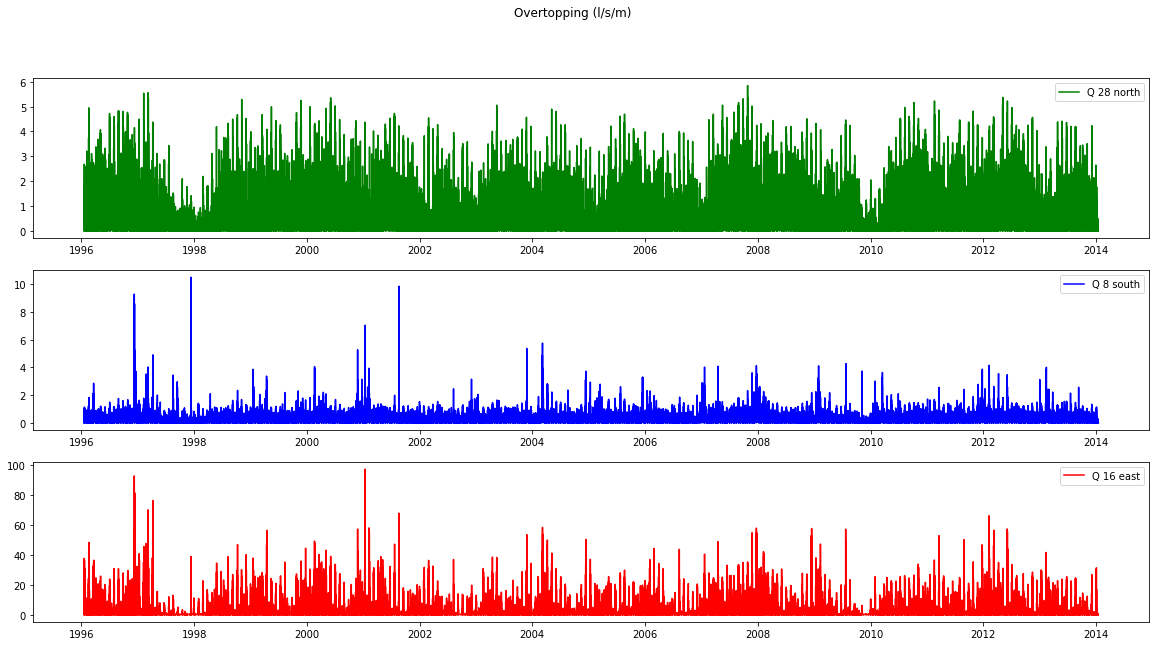

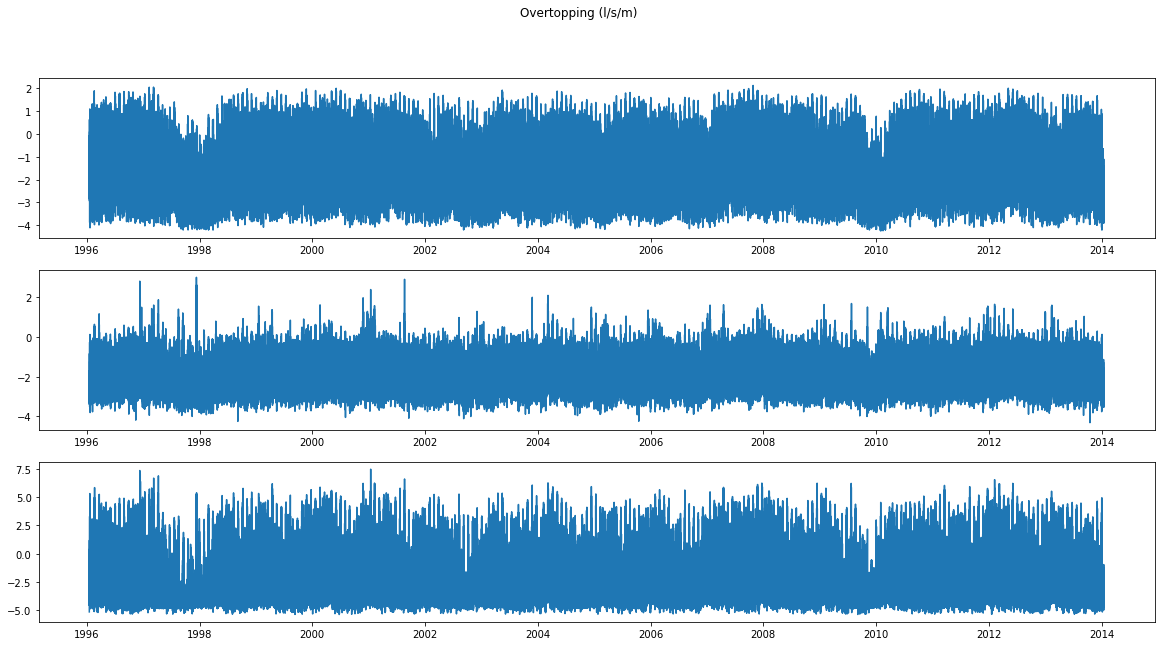

In [5]:
fig, axs = plt.subplots(3,1, figsize=(20,10))

axs[0].plot(out_sim_N.time, out_sim_N.Qinv, color='g', label='Q ' + str(pN) + ' north')
axs[1].plot(out_sim_S.time, out_sim_S.Qinv, color='b', label='Q ' + str(pS) + ' south')
axs[2].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q ' + str(pE) + ' east')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.suptitle('Overtopping (l/s/m)')


fig, axs = plt.subplots(3,1, figsize=(20,10))

axs[0].plot(out_sim_N.time, out_sim_N.Q, label='Q ' + str(pN) + ' north')
axs[1].plot(out_sim_S.time, out_sim_S.Q, label='Q South')
axs[2].plot(out_sim_E.time, out_sim_E.Q, label='Q East')

plt.suptitle('Overtopping (l/s/m)')

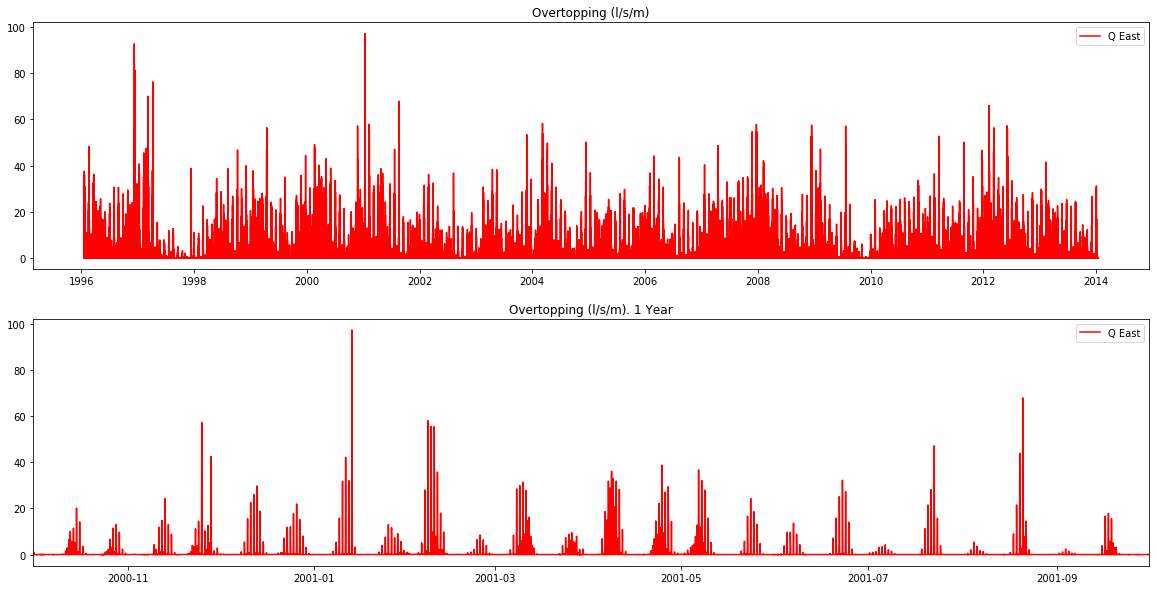

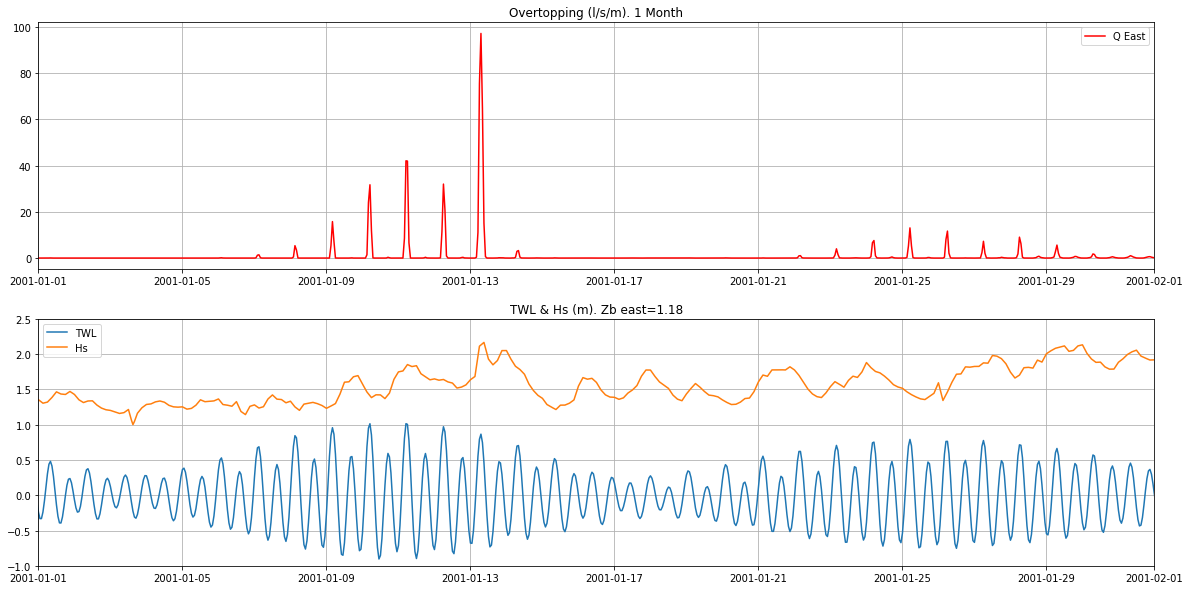

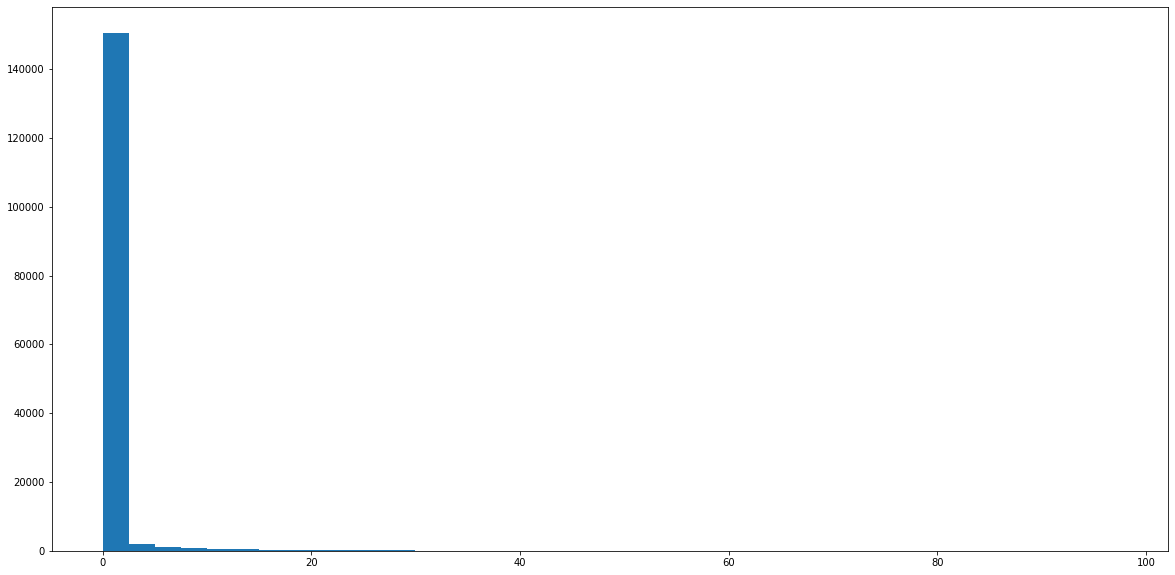

[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100. ]

[8.24227269e-28 5.41580620e-08 3.41303351e-07 1.22559886e-06
 3.00250213e-06 5.90318808e-06 1.04447433e-05 1.74200356e-05
 2.75359765e-05 4.28131205e-05 6.40559550e-05 9.51299648e-05
 1.39634722e-04 2.00531429e-04 2.79824421e-04 3.82047950e-04
 5.12073513e-04 6.77951539e-04 8.86041726e-04 1.13236915e-03
 1.42676020e-03 1.78003265e-03 2.18371161e-03 2.65814183e-03
 3.18521984e-03 3.78286132e-03 4.47098756e-03 5.27907772e-03
 6.25528522e-03 7.48774265e-03 9.13136860e-03 1.15671404e-02
 1.53090999e-02 2.21917811e-02 3.73026217e-02 7.10962553e-02
 1.49853790e-01 4.14371033e-01 1.45323244e+00 5.73202599e+00
 9.72452968e+01]


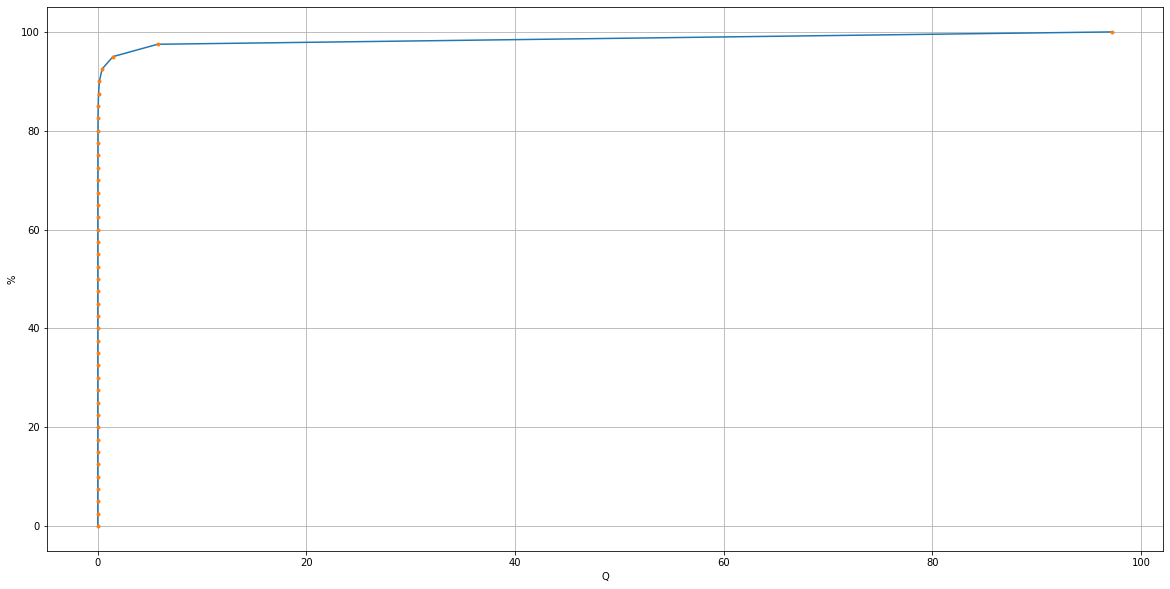

In [26]:
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[0].set_title('Overtopping (l/s/m)')

# zoom 1 year
axs[1].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[1].legend()
axs[1].set_title('Overtopping (l/s/m). 1 Year')
axs[1].set_xlim(datetime(2000,10,1),datetime(2001,10,1))


# zoom 1 month
fig, axs = plt.subplots(2,1,figsize=(20,10))
axs[0].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[0].set_title('Overtopping (l/s/m). 1 Month')
axs[0].set_xlim(datetime(2001,1,1),datetime(2001,2,1))
axs[0].grid()

# plot TWL
axs[1].plot(level.time, level.level, label = 'TWL')
axs[1].plot(out_sim_E.time, out_sim_E.hs, label = 'Hs')
axs[1].legend()
axs[1].set_xlim(datetime(2001,1,1),datetime(2001,2,1))
axs[1].set_ylim(-1, 2.5)
axs[1].set_title('TWL & Hs (m). Zb east=' + str(round(out_sim_E.Zb.values[0],2)))
axs[1].grid()


# histogram
plt.figure(figsize=(20,10))
bins_number = 40 #100 
bins = np.linspace(np.nanmin(out_sim_E.Qinv.values), np.nanmax(out_sim_E.Qinv.values), bins_number)

n, _, _ = plt.hist(out_sim_E.Qinv.values, bins)
plt.show()

# percentiles
q = np.linspace(0,100,bins_number+1)
perc = np.nanpercentile(out_sim_E.Qinv.values, q)

plt.figure(figsize=(20,10))
plt.plot(perc, q)
plt.plot(perc, q, '.')
plt.xlabel('Q')
plt.ylabel('%')
plt.grid()

print(q)
print()
print(perc)